## 3.4.2 微调实例
    微调允许修改预先训练好的网络参数来学习目标任务，所以，训练时间要比特征抽取方法长，但精度更高。微调的大致过程是在预先训练过的网络上添加新的随机初始化层，此外预先训练的网络参数也会被更新，但会使用较小的学习率以防止预先训练好的参数发生较大改变。
    常用方法是固定底层的参数，调整一些顶层或具体层的参数。这样做可以减少训练参数的数量，也有助于克服过拟合现象的发生。尤其是在目标任务的数据量不够大的时候，该方法会很有效。实际上，微调要优于特征提取，因为它能够对迁移过来的预训练网络参数进行优化，使其更加适合新的任务。

### 1.数据预处理
	这里对训练数据的添加了几种数据增强方法，如图片裁剪、旋转、颜色改变等方法。测试数据与特征提取一样，没有变化。

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from datetime import datetime

In [2]:
trans_train = transforms.Compose(
    [transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
     transforms.RandomRotation(degrees=15),
     transforms.ColorJitter(),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),     
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
#如果是linux环境,root的值改为root='./data'，其它不变
trainset = torchvision.datasets.CIFAR10(root='.\data', train=True,
                                        download=False, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.\data', train=False,
                                       download=False, transform=trans_valid)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


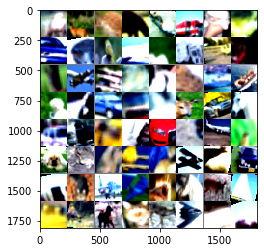

 deer  deer  deer horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 显示图像

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 显示图像
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
images.shape

torch.Size([64, 3, 224, 224])

### 2. 加载预训练模型
加载预训练模型，代码如下：

In [5]:
# 使用预训练的模型
net = models.resnet18(pretrained=True)
#print(net)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\wumgapp/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


In [6]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. 修改分类器
	修改最后全连接层，把类别数由原来的1000改为10。

In [7]:
# 将最后的全连接层改成十分类
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.fc = nn.Linear(512, 10)
#net = torch.nn.DataParallel(net)
net.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# 打出第一层的权重
print(net.conv1.weight.type())

torch.cuda.FloatTensor


### 4. 选择损失函数及优化器
	使用微调训练模型时，一般选择一个稍大一点学习率，如果选择太小，效果要差一些。这里学习率设为le-3。

In [9]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-3,momentum=0.9)

### 5. 训练及验证模型
训练及验证模型，代码如下

In [11]:
def train(net, train_data, valid_data, num_epochs, optimizer, criterion):
   
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        for im, label in train_data:
            im = im.to(device)  # (bs, 3, h, w)
            label = label.to(device) # (bs, h, w)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                im = im.to(device)  # (bs, 3, h, w)
                label = label.to(device) # (bs, h, w)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [12]:
train(net, trainloader, testloader, 20, optimizer, criterion)

Epoch 0. Train Loss: 1.062303, Train Acc: 0.628656, Valid Loss: 0.363401, Valid Acc: 0.877588, Time 00:02:10
Epoch 1. Train Loss: 0.694924, Train Acc: 0.757793, Valid Loss: 0.269816, Valid Acc: 0.906449, Time 00:02:21
Epoch 2. Train Loss: 0.619971, Train Acc: 0.784667, Valid Loss: 0.260177, Valid Acc: 0.908639, Time 00:02:22
Epoch 3. Train Loss: 0.571650, Train Acc: 0.800272, Valid Loss: 0.219722, Valid Acc: 0.922472, Time 00:02:22
Epoch 4. Train Loss: 0.539221, Train Acc: 0.811481, Valid Loss: 0.196439, Valid Acc: 0.929837, Time 00:02:23
Epoch 5. Train Loss: 0.513665, Train Acc: 0.821272, Valid Loss: 0.192957, Valid Acc: 0.933818, Time 00:02:24
Epoch 6. Train Loss: 0.491690, Train Acc: 0.829164, Valid Loss: 0.180844, Valid Acc: 0.937898, Time 00:02:23
Epoch 7. Train Loss: 0.482031, Train Acc: 0.833700, Valid Loss: 0.174707, Valid Acc: 0.940287, Time 00:02:23
Epoch 8. Train Loss: 0.466501, Train Acc: 0.838395, Valid Loss: 0.171810, Valid Acc: 0.942377, Time 00:02:23
Epoch 9. Train Loss

使用微调训练的时间明显大于使用特征抽取的时间，但验证准确率高达95%，因时间关系这里只循环20次，如果增加循环次数，应该还可再提升几个百分点。